<a href="https://colab.research.google.com/github/hyanquiv/cnn-tests/blob/master/simpsonsMnist/simpsons_minist_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!unzip /content/dataset.zip -d /content

Archive:  /content/dataset.zip
replace /content/dataset/test/bart_simpson/pic_0016.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [18]:
# CNN para Simpson MNIST Dataset - Entrenamiento Completo en Google Colab
# ====================================================================

# PASO 1: INSTALACIÓN Y CONFIGURACIÓN INICIAL
# ============================================

# Verificar y configurar GPU
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import os
from PIL import Image
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Verificar disponibilidad de GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo utilizado: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memoria GPU disponible: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Dispositivo utilizado: cuda
GPU: Tesla T4
Memoria GPU disponible: 14.7 GB


In [19]:
# PASO 2: EXPLORACIÓN DEL DATASET
# ===============================

def explore_dataset(data_path):
    """Explora la estructura del dataset"""
    print(f"\n=== EXPLORACIÓN DEL DATASET ===")
    print(f"Ruta del dataset: {data_path}")

    # Verificar existencia de directorios
    train_path = os.path.join(data_path, 'train')
    test_path = os.path.join(data_path, 'test')

    if not os.path.exists(train_path):
        print(f"❌ No se encontró: {train_path}")
        return None, None
    if not os.path.exists(test_path):
        print(f"❌ No se encontró: {test_path}")
        return None, None

    # Explorar clases (personajes)
    classes = sorted(os.listdir(train_path))
    print(f"\n📁 Clases encontradas ({len(classes)}):")

    train_counts = {}
    test_counts = {}

    for i, class_name in enumerate(classes):
        train_class_path = os.path.join(train_path, class_name)
        test_class_path = os.path.join(test_path, class_name)

        train_count = len(os.listdir(train_class_path)) if os.path.exists(train_class_path) else 0
        test_count = len(os.listdir(test_class_path)) if os.path.exists(test_class_path) else 0

        train_counts[class_name] = train_count
        test_counts[class_name] = test_count

        print(f"  {i:2d}. {class_name:<15} - Train: {train_count:4d} | Test: {test_count:4d}")

    total_train = sum(train_counts.values())
    total_test = sum(test_counts.values())
    print(f"\n📊 Total imágenes - Train: {total_train} | Test: {total_test}")

    return classes, (train_counts, test_counts)

def visualize_sample_images(data_path, classes, num_samples=3):
    """Visualiza imágenes de muestra de cada clase"""
    print(f"\n=== VISUALIZACIÓN DE MUESTRAS ===")

    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 3*len(classes)))
    fig.suptitle('Muestras del Dataset Simpson MNIST', fontsize=16, fontweight='bold')

    for i, class_name in enumerate(classes):
        class_path = os.path.join(data_path, 'train', class_name)
        images = os.listdir(class_path)[:num_samples]

        for j, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)

            if len(classes) == 1:
                ax = axes[j]
            else:
                ax = axes[i, j] if num_samples > 1 else axes[i]

            ax.imshow(img)
            ax.set_title(f'{class_name}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

    # Mostrar información de una imagen
    sample_img_path = os.path.join(data_path, 'train', classes[0], os.listdir(os.path.join(data_path, 'train', classes[0]))[0])
    sample_img = Image.open(sample_img_path)
    print(f"📸 Dimensiones de imagen: {sample_img.size}")
    print(f"📸 Modo de color: {sample_img.mode}")
    print(f"📸 Formato: {sample_img.format}")

In [20]:
# PASO 3: DEFINICIÓN DE TRANSFORMACIONES
# ======================================

def get_transforms(use_color=True, augment=True):
    """Define las transformaciones para el dataset"""
    print(f"\n=== CONFIGURACIÓN DE TRANSFORMACIONES ===")
    print(f"🎨 Usar color: {'Sí' if use_color else 'No (Grayscale)'}")
    print(f"🔄 Aumentación de datos: {'Sí' if augment else 'No'}")

    # Transformaciones base
    base_transforms = [
        transforms.Resize((32, 32)),  # Redimensionar para mejor procesamiento
        transforms.ToTensor(),
    ]

    # Convertir a grayscale si es necesario
    if not use_color:
        base_transforms.insert(-1, transforms.Grayscale(num_output_channels=1))

    # Normalización
    if use_color:
        base_transforms.append(transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                  std=[0.229, 0.224, 0.225]))
    else:
        base_transforms.append(transforms.Normalize(mean=[0.5], std=[0.5]))

    # Transformaciones de entrenamiento (con aumentación)
    if augment:
        train_transforms = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1) if use_color else transforms.Lambda(lambda x: x),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        ] + ([] if use_color else [transforms.Grayscale(num_output_channels=1)]) + [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) if use_color
            else transforms.Normalize(mean=[0.5], std=[0.5])
        ])
    else:
        train_transforms = transforms.Compose(base_transforms)

    # Transformaciones de test (sin aumentación)
    test_transforms = transforms.Compose(base_transforms)

    return train_transforms, test_transforms

In [21]:
# PASO 4: DEFINICIÓN DE LA ARQUITECTURA CNN
# =========================================

class SimpsonCNN(nn.Module):
    """Red Neuronal Convolucional para clasificación de personajes de Simpson"""

    def __init__(self, num_classes, input_channels=3, dropout_rate=0.5):
        super(SimpsonCNN, self).__init__()
        print(f"\n=== ARQUITECTURA DE LA RED ===")
        print(f"🧠 Canales de entrada: {input_channels}")
        print(f"🎯 Número de clases: {num_classes}")
        print(f"🔄 Dropout rate: {dropout_rate}")

        # Primer bloque convolucional
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(dropout_rate * 0.25)
        )

        # Segundo bloque convolucional
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(dropout_rate * 0.5)
        )

        # Tercer bloque convolucional
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(dropout_rate * 0.75)
        )

        # Clasificador
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

        # Inicialización de pesos
        self._initialize_weights()

        # Contar parámetros
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"📊 Parámetros totales: {total_params:,}")
        print(f"📊 Parámetros entrenables: {trainable_params:,}")

    def _initialize_weights(self):
        """Inicializa los pesos de la red"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.classifier(x)
        return x

In [22]:
# PASO 5: FUNCIÓN DE ENTRENAMIENTO
# ================================

def train_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """Entrena el modelo por una época"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f'Época {epoch+1} - Entrenamiento')

    for batch_idx, (data, targets) in enumerate(pbar):
        data, targets = data.to(device), targets.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Estadísticas
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # Actualizar barra de progreso
        pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device, epoch):
    """Valida el modelo"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        pbar = tqdm(val_loader, desc=f'Época {epoch+1} - Validación')

        for batch_idx, (data, targets) in enumerate(pbar):
            data, targets = data.to(device), targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # Guardar predicciones para métricas
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc, all_predictions, all_targets

In [23]:
# PASO 6: FUNCIÓN PRINCIPAL DE ENTRENAMIENTO
# ==========================================

def train_model(model, train_loader, val_loader, num_epochs, device, learning_rate=0.001):
    """Entrena el modelo completo"""
    print(f"\n=== INICIO DEL ENTRENAMIENTO ===")
    print(f"🎯 Épocas: {num_epochs}")
    print(f"📚 Lotes de entrenamiento: {len(train_loader)}")
    print(f"🧪 Lotes de validación: {len(val_loader)}")
    print(f"🚀 Learning rate: {learning_rate}")

    # Definir criterio y optimizador
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # Listas para guardar métricas
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    best_val_acc = 0.0
    best_model_state = None

    print(f"\n🏁 Comenzando entrenamiento...")
    start_time = time.time()

    for epoch in range(num_epochs):
        print(f"\n--- Época {epoch+1}/{num_epochs} ---")

        # Entrenamiento
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, epoch)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validación
        val_loss, val_acc, val_preds, val_targets = validate_epoch(model, val_loader, criterion, device, epoch)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Actualizar scheduler
        scheduler.step(val_loss)

        # Guardar mejor modelo
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            print(f"🎉 ¡Nuevo mejor modelo! Accuracy: {val_acc:.2f}%")

        # Resumen de época
        print(f"📊 Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"📊 Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"📊 Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

    # Cargar mejor modelo
    model.load_state_dict(best_model_state)

    total_time = time.time() - start_time
    print(f"\n🏆 ENTRENAMIENTO COMPLETADO")
    print(f"⏱️ Tiempo total: {total_time/60:.2f} minutos")
    print(f"🎯 Mejor accuracy de validación: {best_val_acc:.2f}%")

    return {
        'model': model,
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc
    }

In [24]:
# PASO 7: EVALUACIÓN Y MÉTRICAS
# =============================

def evaluate_model(model, test_loader, classes, device):
    """Evalúa el modelo y calcula métricas detalladas"""
    print(f"\n=== EVALUACIÓN DEL MODELO ===")

    model.eval()
    all_predictions = []
    all_targets = []
    all_probabilities = []

    with torch.no_grad():
        pbar = tqdm(test_loader, desc='Evaluando modelo')

        for data, targets in pbar:
            data, targets = data.to(device), targets.to(device)

            outputs = model(data)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    # Calcular métricas
    accuracy = accuracy_score(all_targets, all_predictions)
    precision, recall, f1, support = precision_recall_fscore_support(
        all_targets, all_predictions, average='weighted'
    )

    print(f"\n📊 MÉTRICAS GENERALES:")
    print(f"🎯 Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"🎯 Precision: {precision:.4f}")
    print(f"🎯 Recall: {recall:.4f}")
    print(f"🎯 F1-Score: {f1:.4f}")

    # Reporte detallado por clase
    print(f"\n📋 REPORTE POR CLASE:")
    class_report = classification_report(
        all_targets, all_predictions,
        target_names=classes,
        output_dict=True
    )

    for class_name in classes:
        metrics = class_report[class_name]
        print(f"  {class_name:<15} - P: {metrics['precision']:.3f} | R: {metrics['recall']:.3f} | F1: {metrics['f1-score']:.3f} | Support: {int(metrics['support'])}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_predictions,
        'targets': all_targets,
        'probabilities': all_probabilities,
        'class_report': class_report
    }

In [25]:
# PASO 8: VISUALIZACIÓN DE RESULTADOS
# ===================================

def plot_training_history(history):
    """Grafica el historial de entrenamiento"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Pérdida
    epochs = range(1, len(history['train_losses']) + 1)
    ax1.plot(epochs, history['train_losses'], 'b-', label='Entrenamiento', linewidth=2)
    ax1.plot(epochs, history['val_losses'], 'r-', label='Validación', linewidth=2)
    ax1.set_title('Pérdida Durante el Entrenamiento', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Pérdida')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy
    ax2.plot(epochs, history['train_accs'], 'b-', label='Entrenamiento', linewidth=2)
    ax2.plot(epochs, history['val_accs'], 'r-', label='Validación', linewidth=2)
    ax2.set_title('Accuracy Durante el Entrenamiento', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Épocas')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(targets, predictions, classes):
    """Grafica la matriz de confusión"""
    cm = confusion_matrix(targets, predictions)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Matriz de Confusión', fontsize=16, fontweight='bold')
    plt.xlabel('Predicción', fontsize=12)
    plt.ylabel('Verdadero', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_class_performance(class_report, classes):
    """Grafica el rendimiento por clase"""
    metrics = ['precision', 'recall', 'f1-score']

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, metric in enumerate(metrics):
        values = [class_report[class_name][metric] for class_name in classes]

        bars = axes[i].bar(range(len(classes)), values, alpha=0.7,
                          color=plt.cm.viridis(np.linspace(0, 1, len(classes))))
        axes[i].set_title(f'{metric.capitalize()} por Clase', fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Clases')
        axes[i].set_ylabel(metric.capitalize())
        axes[i].set_xticks(range(len(classes)))
        axes[i].set_xticklabels(classes, rotation=45, ha='right')
        axes[i].grid(True, alpha=0.3)

        # Añadir valores en las barras
        for j, bar in enumerate(bars):
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{height:.3f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

🎬 ENTRENAMIENTO CNN - SIMPSON MNIST DATASET

=== EXPLORACIÓN DEL DATASET ===
Ruta del dataset: /content/dataset

📁 Clases encontradas (10):
   0. bart_simpson    - Train:  800 | Test:  200
   1. charles_montgomery_burns - Train:  800 | Test:  200
   2. homer_simpson   - Train:  800 | Test:  200
   3. krusty_the_clown - Train:  800 | Test:  200
   4. lisa_simpson    - Train:  800 | Test:  200
   5. marge_simpson   - Train:  800 | Test:  200
   6. milhouse_van_houten - Train:  800 | Test:  200
   7. moe_szyslak     - Train:  800 | Test:  200
   8. ned_flanders    - Train:  800 | Test:  200
   9. principal_skinner - Train:  800 | Test:  200

📊 Total imágenes - Train: 8000 | Test: 2000

=== VISUALIZACIÓN DE MUESTRAS ===


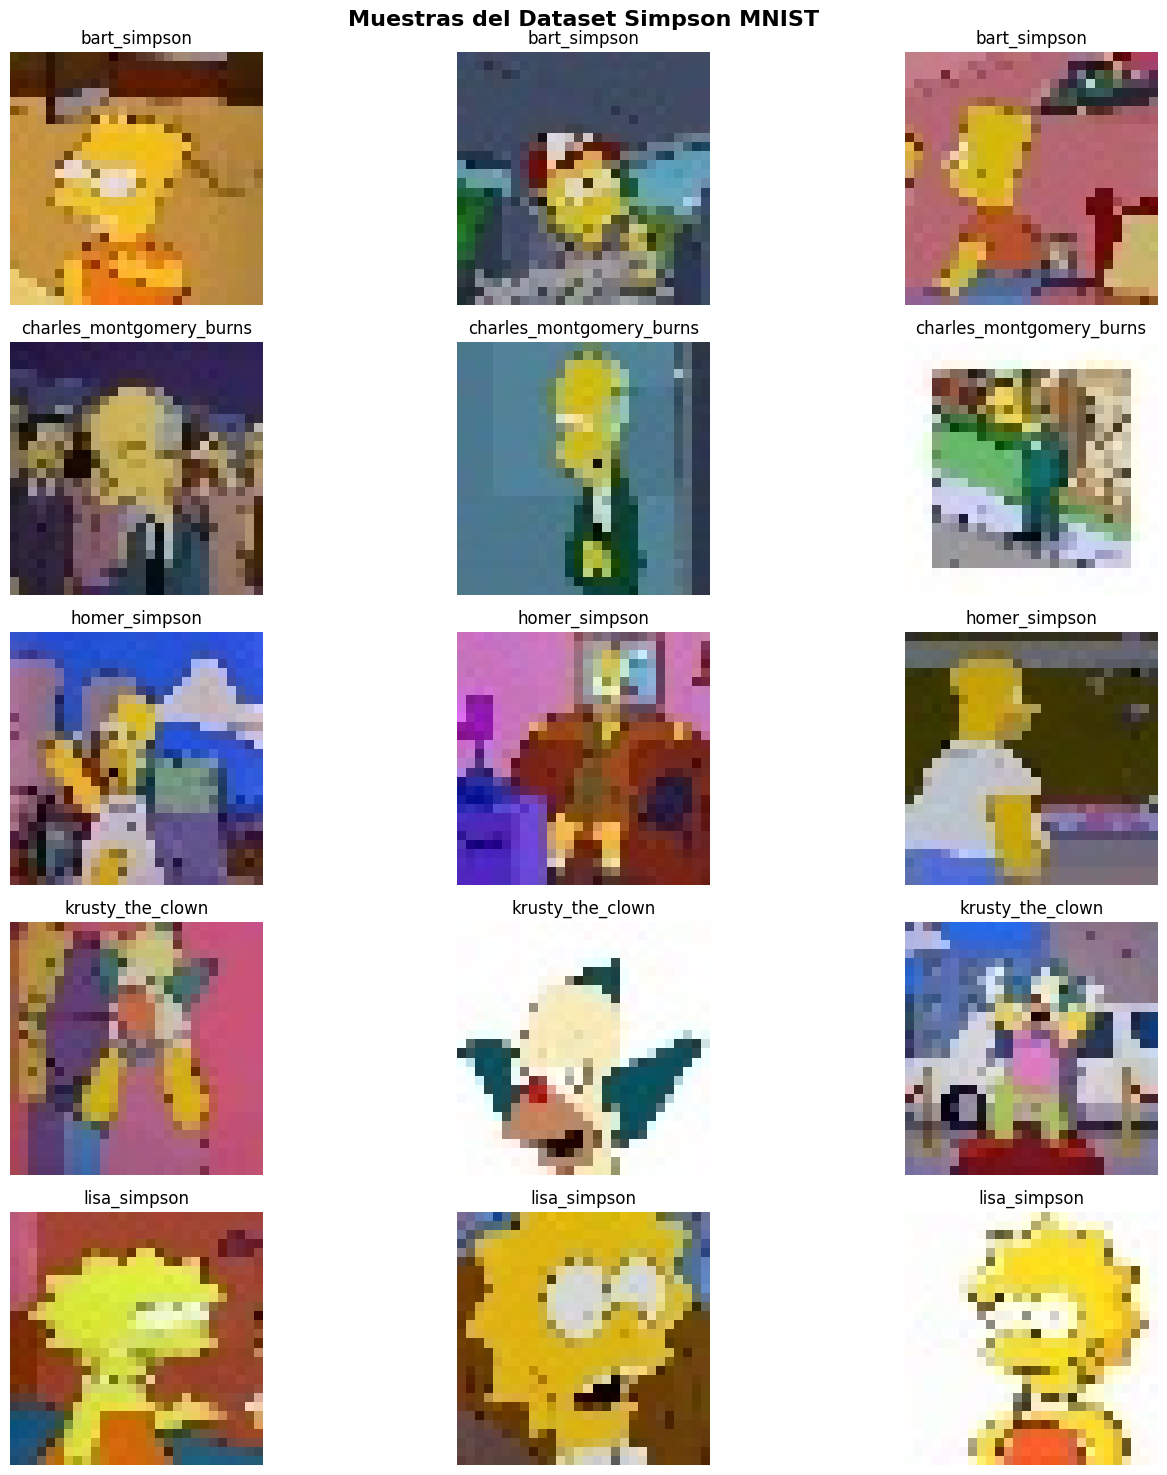

📸 Dimensiones de imagen: (28, 28)
📸 Modo de color: RGB
📸 Formato: JPEG

=== CONFIGURACIÓN DE TRANSFORMACIONES ===
🎨 Usar color: Sí
🔄 Aumentación de datos: Sí

📊 CONFIGURACIÓN FINAL:
🎨 Modo de color: RGB
📦 Tamaño de lote: 32
🔄 Épocas: 20
🎯 Clases: 10
📚 Imágenes de entrenamiento: 8000
🧪 Imágenes de prueba: 2000

=== ARQUITECTURA DE LA RED ===
🧠 Canales de entrada: 3
🎯 Número de clases: 10
🔄 Dropout rate: 0.5
📊 Parámetros totales: 355,882
📊 Parámetros entrenables: 355,882

=== INICIO DEL ENTRENAMIENTO ===
🎯 Épocas: 20
📚 Lotes de entrenamiento: 250
🧪 Lotes de validación: 63
🚀 Learning rate: 0.001

🏁 Comenzando entrenamiento...

--- Época 1/20 ---


Época 1 - Validación: 100%|██████████| 63/63 [00:03<00:00, 19.76it/s, Loss=1.9259, Acc=30.45%]


🎉 ¡Nuevo mejor modelo! Accuracy: 30.45%
📊 Train Loss: 2.2033 | Train Acc: 19.18%
📊 Val Loss: 1.9259 | Val Acc: 30.45%
📊 Learning Rate: 0.001000

--- Época 2/20 ---


Época 2 - Validación: 100%|██████████| 63/63 [00:01<00:00, 31.90it/s, Loss=1.7027, Acc=38.60%]


🎉 ¡Nuevo mejor modelo! Accuracy: 38.60%
📊 Train Loss: 1.9772 | Train Acc: 29.70%
📊 Val Loss: 1.7027 | Val Acc: 38.60%
📊 Learning Rate: 0.001000

--- Época 3/20 ---


Época 3 - Validación: 100%|██████████| 63/63 [00:01<00:00, 32.42it/s, Loss=1.6408, Acc=44.55%]


🎉 ¡Nuevo mejor modelo! Accuracy: 44.55%
📊 Train Loss: 1.8144 | Train Acc: 36.90%
📊 Val Loss: 1.6408 | Val Acc: 44.55%
📊 Learning Rate: 0.001000

--- Época 4/20 ---


Época 4 - Validación: 100%|██████████| 63/63 [00:01<00:00, 47.31it/s, Loss=1.4144, Acc=52.30%]


🎉 ¡Nuevo mejor modelo! Accuracy: 52.30%
📊 Train Loss: 1.6792 | Train Acc: 42.40%
📊 Val Loss: 1.4144 | Val Acc: 52.30%
📊 Learning Rate: 0.001000

--- Época 5/20 ---


Época 5 - Validación: 100%|██████████| 63/63 [00:01<00:00, 52.07it/s, Loss=1.2309, Acc=57.75%]


🎉 ¡Nuevo mejor modelo! Accuracy: 57.75%
📊 Train Loss: 1.5602 | Train Acc: 46.52%
📊 Val Loss: 1.2309 | Val Acc: 57.75%
📊 Learning Rate: 0.001000

--- Época 6/20 ---


Época 6 - Validación: 100%|██████████| 63/63 [00:01<00:00, 50.85it/s, Loss=1.1172, Acc=61.75%]


🎉 ¡Nuevo mejor modelo! Accuracy: 61.75%
📊 Train Loss: 1.4794 | Train Acc: 49.58%
📊 Val Loss: 1.1172 | Val Acc: 61.75%
📊 Learning Rate: 0.001000

--- Época 7/20 ---


Época 7 - Validación: 100%|██████████| 63/63 [00:01<00:00, 52.50it/s, Loss=1.0329, Acc=63.40%]


🎉 ¡Nuevo mejor modelo! Accuracy: 63.40%
📊 Train Loss: 1.3826 | Train Acc: 52.80%
📊 Val Loss: 1.0329 | Val Acc: 63.40%
📊 Learning Rate: 0.001000

--- Época 8/20 ---


Época 8 - Validación: 100%|██████████| 63/63 [00:01<00:00, 51.56it/s, Loss=0.9511, Acc=67.20%]


🎉 ¡Nuevo mejor modelo! Accuracy: 67.20%
📊 Train Loss: 1.3157 | Train Acc: 55.49%
📊 Val Loss: 0.9511 | Val Acc: 67.20%
📊 Learning Rate: 0.001000

--- Época 9/20 ---


Época 9 - Validación: 100%|██████████| 63/63 [00:01<00:00, 51.50it/s, Loss=0.9009, Acc=67.30%]


🎉 ¡Nuevo mejor modelo! Accuracy: 67.30%
📊 Train Loss: 1.2244 | Train Acc: 59.31%
📊 Val Loss: 0.9009 | Val Acc: 67.30%
📊 Learning Rate: 0.001000

--- Época 10/20 ---


Época 10 - Validación: 100%|██████████| 63/63 [00:01<00:00, 52.79it/s, Loss=0.9367, Acc=67.90%]


🎉 ¡Nuevo mejor modelo! Accuracy: 67.90%
📊 Train Loss: 1.1682 | Train Acc: 60.49%
📊 Val Loss: 0.9367 | Val Acc: 67.90%
📊 Learning Rate: 0.001000

--- Época 11/20 ---


Época 11 - Validación: 100%|██████████| 63/63 [00:01<00:00, 51.77it/s, Loss=0.8298, Acc=70.55%]


🎉 ¡Nuevo mejor modelo! Accuracy: 70.55%
📊 Train Loss: 1.1301 | Train Acc: 61.94%
📊 Val Loss: 0.8298 | Val Acc: 70.55%
📊 Learning Rate: 0.001000

--- Época 12/20 ---


Época 12 - Validación: 100%|██████████| 63/63 [00:01<00:00, 50.47it/s, Loss=0.8012, Acc=71.45%]


🎉 ¡Nuevo mejor modelo! Accuracy: 71.45%
📊 Train Loss: 1.0950 | Train Acc: 63.30%
📊 Val Loss: 0.8012 | Val Acc: 71.45%
📊 Learning Rate: 0.001000

--- Época 13/20 ---


Época 13 - Validación: 100%|██████████| 63/63 [00:01<00:00, 50.32it/s, Loss=0.6708, Acc=77.05%]


🎉 ¡Nuevo mejor modelo! Accuracy: 77.05%
📊 Train Loss: 1.0335 | Train Acc: 65.67%
📊 Val Loss: 0.6708 | Val Acc: 77.05%
📊 Learning Rate: 0.001000

--- Época 14/20 ---


Época 14 - Validación: 100%|██████████| 63/63 [00:01<00:00, 50.38it/s, Loss=0.7163, Acc=75.50%]


📊 Train Loss: 0.9984 | Train Acc: 66.58%
📊 Val Loss: 0.7163 | Val Acc: 75.50%
📊 Learning Rate: 0.001000

--- Época 15/20 ---


Época 15 - Validación: 100%|██████████| 63/63 [00:01<00:00, 46.10it/s, Loss=0.6821, Acc=75.85%]


📊 Train Loss: 0.9858 | Train Acc: 67.25%
📊 Val Loss: 0.6821 | Val Acc: 75.85%
📊 Learning Rate: 0.001000

--- Época 16/20 ---


Época 16 - Validación: 100%|██████████| 63/63 [00:01<00:00, 38.01it/s, Loss=0.6359, Acc=78.45%]


🎉 ¡Nuevo mejor modelo! Accuracy: 78.45%
📊 Train Loss: 0.9488 | Train Acc: 68.44%
📊 Val Loss: 0.6359 | Val Acc: 78.45%
📊 Learning Rate: 0.001000

--- Época 17/20 ---


Época 17 - Validación: 100%|██████████| 63/63 [00:01<00:00, 34.89it/s, Loss=0.6151, Acc=78.95%]


🎉 ¡Nuevo mejor modelo! Accuracy: 78.95%
📊 Train Loss: 0.9203 | Train Acc: 69.06%
📊 Val Loss: 0.6151 | Val Acc: 78.95%
📊 Learning Rate: 0.001000

--- Época 18/20 ---


Época 18 - Validación: 100%|██████████| 63/63 [00:01<00:00, 36.82it/s, Loss=0.6454, Acc=76.90%]


📊 Train Loss: 0.9050 | Train Acc: 70.26%
📊 Val Loss: 0.6454 | Val Acc: 76.90%
📊 Learning Rate: 0.001000

--- Época 19/20 ---


Época 19 - Validación: 100%|██████████| 63/63 [00:01<00:00, 43.59it/s, Loss=0.6172, Acc=78.95%]


📊 Train Loss: 0.8847 | Train Acc: 70.91%
📊 Val Loss: 0.6172 | Val Acc: 78.95%
📊 Learning Rate: 0.001000

--- Época 20/20 ---


Época 20 - Validación: 100%|██████████| 63/63 [00:01<00:00, 49.96it/s, Loss=0.6010, Acc=79.40%]


🎉 ¡Nuevo mejor modelo! Accuracy: 79.40%
📊 Train Loss: 0.8430 | Train Acc: 72.50%
📊 Val Loss: 0.6010 | Val Acc: 79.40%
📊 Learning Rate: 0.001000

🏆 ENTRENAMIENTO COMPLETADO
⏱️ Tiempo total: 4.23 minutos
🎯 Mejor accuracy de validación: 79.40%


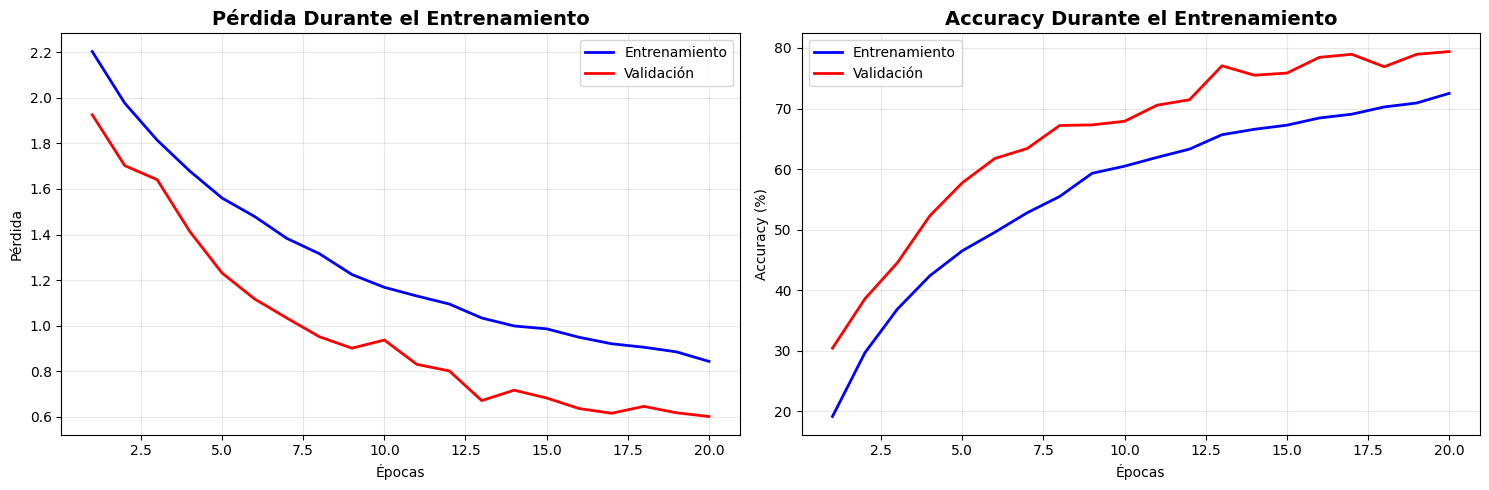


=== EVALUACIÓN DEL MODELO ===


Evaluando modelo: 100%|██████████| 63/63 [00:01<00:00, 35.46it/s]



📊 MÉTRICAS GENERALES:
🎯 Accuracy: 0.7940 (79.40%)
🎯 Precision: 0.8009
🎯 Recall: 0.7940
🎯 F1-Score: 0.7890

📋 REPORTE POR CLASE:
  bart_simpson    - P: 0.541 | R: 0.590 | F1: 0.565 | Support: 200
  charles_montgomery_burns - P: 0.750 | R: 0.645 | F1: 0.694 | Support: 200
  homer_simpson   - P: 0.888 | R: 0.675 | F1: 0.767 | Support: 200
  krusty_the_clown - P: 0.951 | R: 0.970 | F1: 0.960 | Support: 200
  lisa_simpson    - P: 0.746 | R: 0.455 | F1: 0.565 | Support: 200
  marge_simpson   - P: 0.945 | R: 0.940 | F1: 0.942 | Support: 200
  milhouse_van_houten - P: 0.859 | R: 0.915 | F1: 0.886 | Support: 200
  moe_szyslak     - P: 0.657 | R: 0.950 | F1: 0.777 | Support: 200
  ned_flanders    - P: 0.869 | R: 0.930 | F1: 0.899 | Support: 200
  principal_skinner - P: 0.802 | R: 0.870 | F1: 0.835 | Support: 200


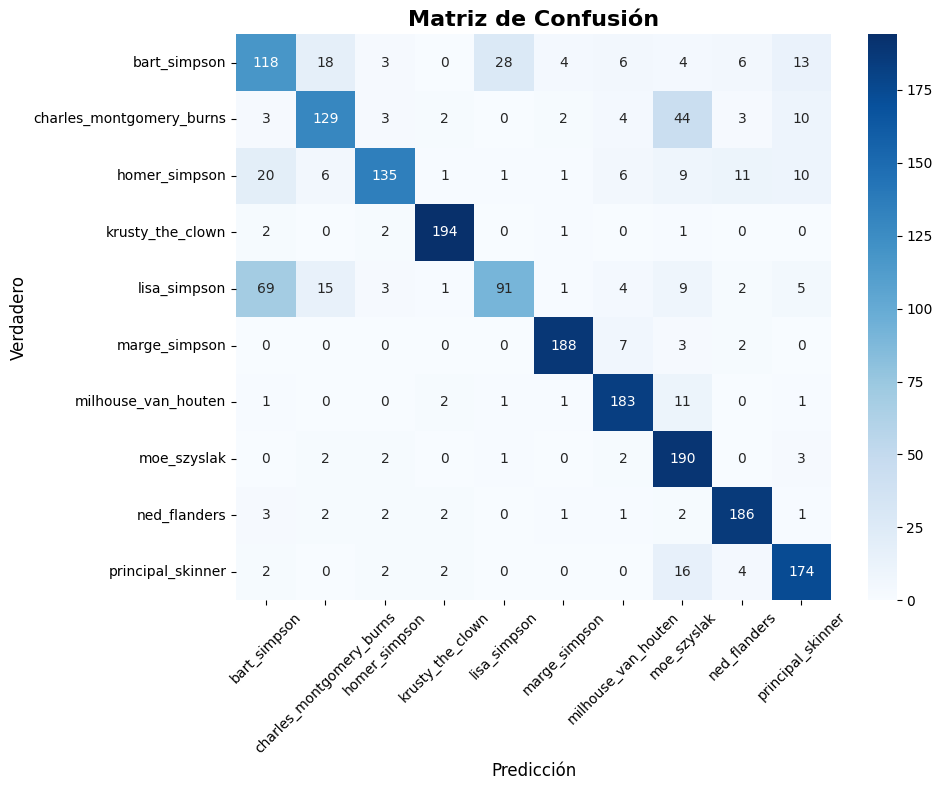

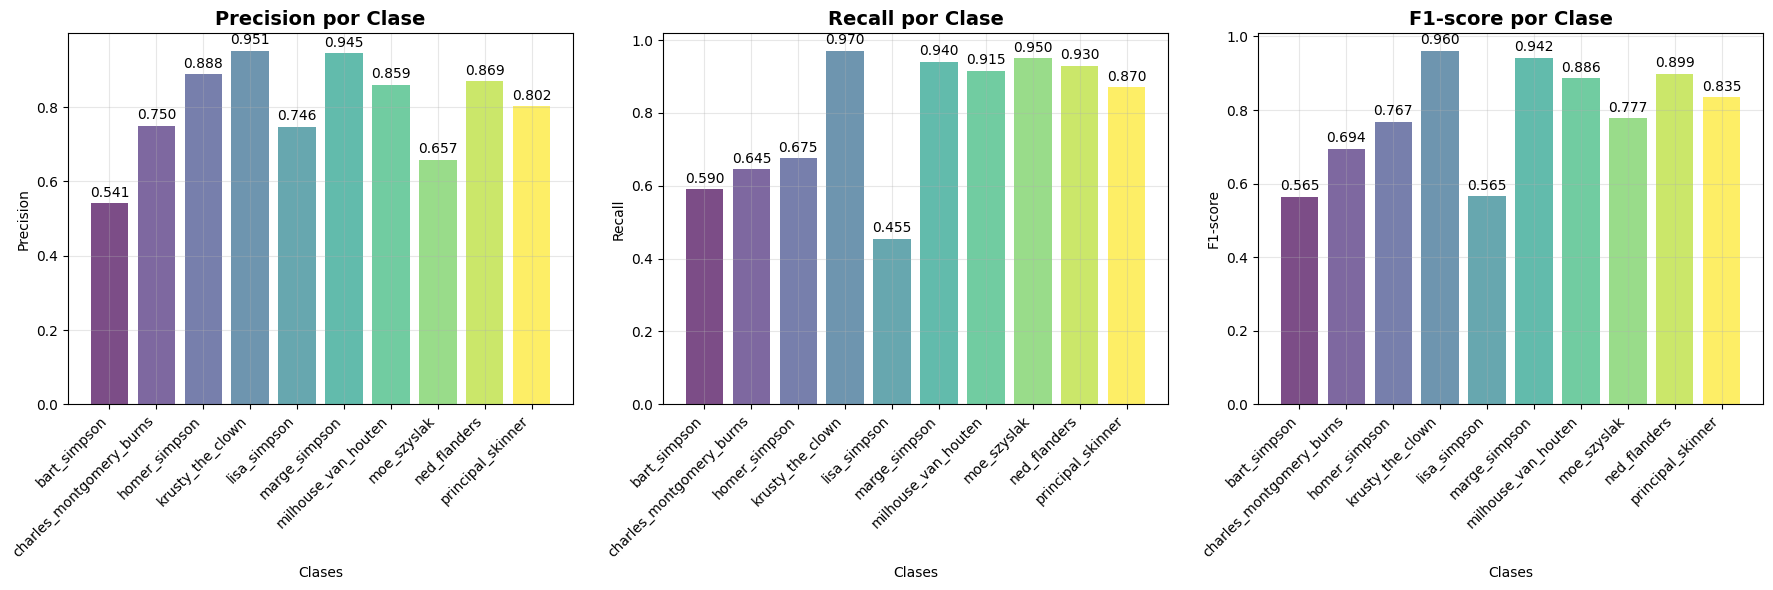


🎉 ¡ENTRENAMIENTO COMPLETADO!
💾 Modelo guardado en: /content/simpson_cnn_model.pth
🏆 Accuracy final: 79.40%
📊 F1-Score: 0.7890


In [26]:
# PASO 9: SCRIPT PRINCIPAL
# ========================

def main():
    """Función principal que ejecuta todo el pipeline"""
    print("🎬 ENTRENAMIENTO CNN - SIMPSON MNIST DATASET")
    print("=" * 50)

    # Configuración
    DATA_PATH = '/content/dataset'
    USE_COLOR = True  # Cambiar a False para grayscale
    BATCH_SIZE = 32
    NUM_EPOCHS = 20
    LEARNING_RATE = 0.001

    # Paso 1: Explorar dataset
    classes, counts = explore_dataset(DATA_PATH)
    if classes is None:
        print("❌ Error: No se pudo cargar el dataset")
        return

    # Paso 2: Visualizar muestras
    visualize_sample_images(DATA_PATH, classes[:5])  # Mostrar solo primeras 5 clases

    # Paso 3: Preparar transformaciones y datasets
    train_transforms, test_transforms = get_transforms(use_color=USE_COLOR, augment=True)

    train_dataset = ImageFolder(
        root=os.path.join(DATA_PATH, 'train'),
        transform=train_transforms
    )

    test_dataset = ImageFolder(
        root=os.path.join(DATA_PATH, 'test'),
        transform=test_transforms
    )

    # DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    print(f"\n📊 CONFIGURACIÓN FINAL:")
    print(f"🎨 Modo de color: {'RGB' if USE_COLOR else 'Grayscale'}")
    print(f"📦 Tamaño de lote: {BATCH_SIZE}")
    print(f"🔄 Épocas: {NUM_EPOCHS}")
    print(f"🎯 Clases: {len(classes)}")
    print(f"📚 Imágenes de entrenamiento: {len(train_dataset)}")
    print(f"🧪 Imágenes de prueba: {len(test_dataset)}")

    # Paso 4: Crear modelo
    input_channels = 3 if USE_COLOR else 1
    model = SimpsonCNN(
        num_classes=len(classes),
        input_channels=input_channels,
        dropout_rate=0.5
    ).to(device)

    # Paso 5: Entrenar modelo
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=test_loader,  # Usando test como validación
        num_epochs=NUM_EPOCHS,
        device=device,
        learning_rate=LEARNING_RATE
    )

    # Paso 6: Visualizar entrenamiento
    plot_training_history(history)

    # Paso 7: Evaluar modelo
    evaluation = evaluate_model(
        model=history['model'],
        test_loader=test_loader,
        classes=classes,
        device=device
    )

    # Paso 8: Visualizar resultados
    plot_confusion_matrix(
        evaluation['targets'],
        evaluation['predictions'],
        classes
    )

    plot_class_performance(
        evaluation['class_report'],
        classes
    )

    # Paso 9: Guardar modelo
    torch.save({
        'model_state_dict': history['model'].state_dict(),
        'classes': classes,
        'input_channels': input_channels,
        'num_classes': len(classes),
        'best_accuracy': history['best_val_acc'],
        'evaluation': evaluation
    }, '/content/simpson_cnn_model.pth')

    print(f"\n🎉 ¡ENTRENAMIENTO COMPLETADO!")
    print(f"💾 Modelo guardado en: /content/simpson_cnn_model.pth")
    print(f"🏆 Accuracy final: {evaluation['accuracy']*100:.2f}%")
    print(f"📊 F1-Score: {evaluation['f1']:.4f}")

# EJECUTAR EL SCRIPT PRINCIPAL
if __name__ == "__main__":
    main()